In this notebook we are going to use transfer learning to make classifications that will group and make predictions whether a picture is of a child or an adult. Now what is transfer learning

Transfer Learning

This refers to re-use of a pretrained model into new machine learning problem as in our case classification of images. Below is an implementation of our model.

In [3]:
#importing prerequisite libraries
import os
import shutil
import matplotlib.pyplot as plt 
import seaborn as sns
import random
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import Model
import  matplotlib. image as mpimg
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage, AnnotationBbox)
import matplotlib.patches as mpatches

Uploading our folder from a local directory.

In [6]:
# assighning path to our directory
import os
path = r'../tochora/baba/child/'


we are going to make a dataframe having classifieed images in the folder into two groups that is  child and Adult and number of images in each group.The dataframe will consist of columns: Tran-test made up of two folders in our dataset that is test and train, labels which consist of Child and non Adult images and finally number of items which has the entries of either smile or non-smile images.

In [7]:
import pandas as pd
# creating empty lists
my_train_test_list = []
mylabels_list = []
myitem_list = []
vis_images = []; vis_labels = []
#returning a list of images contained in the path directory
train_test_list = tf.io.gfile.listdir(path)
# iterating each image in the train_test_list
for train_test in train_test_list:
    #concatenating base directory with each image in train_test_list
    path1 = os.path.join(path, train_test)
    # returning a list of iamges that are going to act as labels
    label_list = os.listdir(path1)
    # iterating each label
    for label in label_list:
        #concatinating each label in label_list with my_path 
        my_path = os.path.join(path1, label)
        # getting a list of files from my_path
        item_files = os.listdir(my_path)
        #
        my_train_test_list.append(train_test)
        mylabels_list.append(label)
        myitem_list.append(len(item_files))
        
        my_files = item_files[0:5]
        for file in my_files:
            # getting each image from respective labels
            vis_images.append(os.path.join(my_path, file))
            # getting each label for each image
            vis_labels.append(label)
            # creating  a dataframe where train_test shows various folders, assign labels and entries in each label
pd.DataFrame({'Train_test':my_train_test_list, 'Labels':mylabels_list, 'Number of items': myitem_list})

,Train_test,Labels,Number of items
0,test,adults,60
1,test,children,60
2,train,adults,340
3,train,children,340


visualizing images in our file with their respective labels

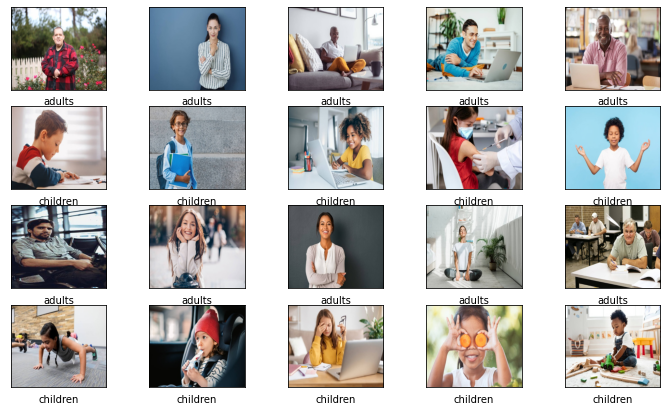

In [ ]:
plt.figure(figsize=(12, 7))
for i in range(len(vis_labels)):
    plt.subplot(4, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = mpimg.imread(vis_images[i])
    plt.imshow(img)
    plt.xlabel(vis_labels[i], color='white')
plt.show()

In [ ]:
import numpy as np

Augmenting our images with imageDatagenerator

we are going to use it to augment images that we have for training .It applies various transformations to our images such scaling, angle changes and verticla shifting.this helps to generate multiple images from an image when one has a dataset that contains small number of images for training a model.This library is helpful especially when one has a small dataset.

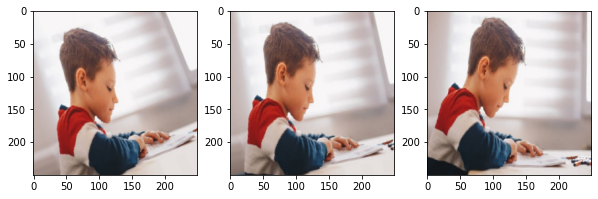

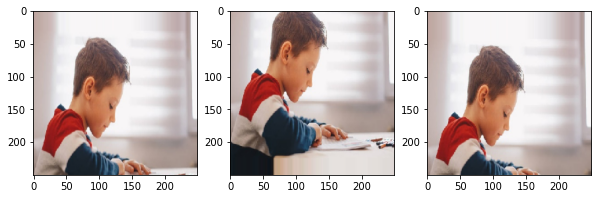

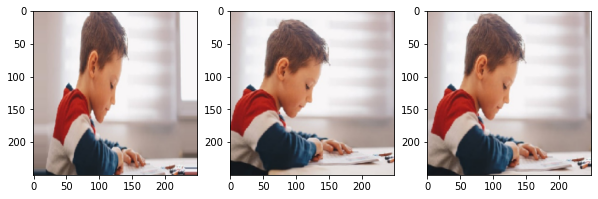

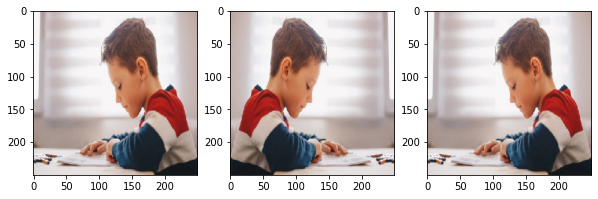

In [ ]:
# a function to generate and transform various images
def Show_ImageDataGenerator(vis_images, vis_labels, image_index):
    class_label = vis_labels[image_index]
    img = tf.keras.preprocessing.image.load_img(vis_images[image_index], target_size=(250, 250))
    img_tensor = tf.keras.preprocessing.image.img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)

    def show_image(datagen, param):
        pic = datagen.flow(img_tensor, batch_size=1)
        plt.figure(figsize=(10, 3.5))

        for i in range(1, 4):
            plt.subplot(1, 3, i)
            batch = pic.next()
            image_ = batch[0].astype('uint8')
            plt.imshow(image_)
    datagen = ImageDataGenerator(rotation_range=30)
    show_image(datagen, 'rotation_range=30')
    datagen = ImageDataGenerator(width_shift_range=0.2)
    show_image(datagen, 'width_shift_rage=0.2')
    datagen = ImageDataGenerator(zoom_range=0.2)
    show_image(datagen, 'zoom_range=0.2')
    datagen = ImageDataGenerator(horizontal_flip=True)
    show_image(datagen, 'horizontal_flip=True')
    # using our function to generate an image of a kid that has undergone various transformations
Show_ImageDataGenerator(vis_images, vis_labels, image_index = 5)

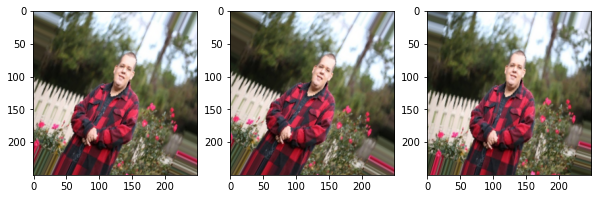

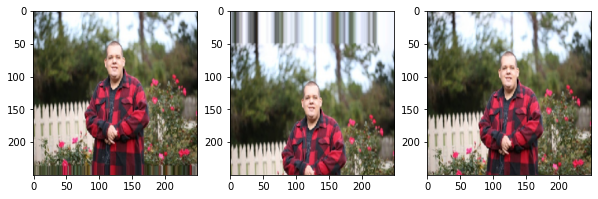

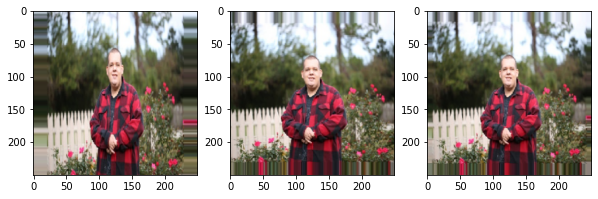

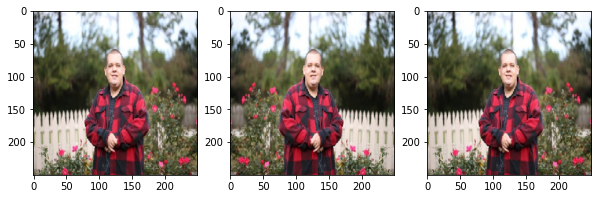

In [ ]:
# generating a picture of an adult that have been applied various transformations
Show_ImageDataGenerator(vis_images, vis_labels, image_index=4)

The above images show how imageDataGenerator can be used to augment images and also to make various alterations on them.

Here, we are going to use imageDataGenerator to make various transformations to our images by using parameters such as rotations , rescaling, vertical shifting etc so as get image vectors for maximum feature extraction  .Flow from directory will help in assigning directory path and generating image batches.

In [ ]:
# a function that our directory into training and validation data
def train_val_generators(Training_Dir, Validation_Dir):
    # appplying various transformations
    train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2,
    zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
    #
    train_generator = train_datagen.flow_from_directory(directory=Training_Dir, batch_size=32, class_mode='binary', target_size=(150, 150))
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(directory=Validation_Dir, batch_size=32, class_mode='binary',target_size=(150, 150))
    return train_generator, validation_generator
    


In [ ]:
# assigning  training dir and validation dir a path
training_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path,'test')
print(validation_dir)

../tochora/child/test


In [ ]:
train_generator, validation_generator = train_val_generators(training_dir, validation_dir)

Found 680 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


training data has 680 images from both adult and child while testing data has 120 images.

Transfer Learning

we are going to use a prettrained model MobileNetV2 which was trained on a big dataset since our dataset is small and only a pretrained model can have better accuracy so as to facilitate predictions.

we will set base_model parameters like weights to be the same with those of imagenet, setting include_top false to avoid top layers of the model from being used.

In [ ]:
# Uploading our model
base_model = tf.keras.applications.MobileNetV2(input_shape=(150,150, 3), include_top=False, weights='imagenet' )
# preventing the weights of our model from being updated the model is trained
base_model.trainable=False
last_ouput = base_model.output
#checking trainable parameters in the model
num_trainable_params = sum([w.shape.num_elements() for w in base_model.trainable_weights])
print(f'there are {num_trainable_params} trainable parameters in this model')
print(f'pretrained model has type: {type(base_model)}')

there are 0 trainable parameters in this model
pretrained model has type: <class 'keras.engine.functional.Functional'>


In [ ]:
def transfer_learning(last_ouput, pre_trained_model):
    # flatten the output layer to one dimension
    x = tf.keras.layers.Flatten()(last_ouput)
    # adding a fully connected layer with 1024 hidden units while using relu activation functio
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # add a sigmoid layer with the purpose of binary classsification
    x = tf.keras.layers.Dropout(0.6)(x)
    # incorporating our model into the model class
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=pre_trained_model.input, outputs=x )
    return model 

model = transfer_learning(last_ouput, base_model)
# summary of our model
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

In [ ]:
# 
model = transfer_learning(last_ouput, base_model)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#defining a callback that will stop our model from training when accuracy reaches 95%
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs={}):
        if (logs.get('accuracy')>0.95):
            print('\n reached 95% accuracy so cancelling training')
            self.model.stop_training = True
callbacks = myCallback()
# fitting our model
history = model.fit(train_generator, epochs=7, validation_data=validation_generator, callbacks=callbacks)


Epoch 1/7
22/22 [==============================] - 60s 2s/step - loss: 13.9820 - accuracy: 0.6294 - val_loss: 8.3848 - val_accuracy: 0.6833
Epoch 2/7
22/22 [==============================] - 35s 2s/step - loss: 7.5965 - accuracy: 0.7162 - val_loss: 8.0813 - val_accuracy: 0.7000
Epoch 3/7
22/22 [==============================] - 35s 2s/step - loss: 4.2927 - accuracy: 0.7103 - val_loss: 1.6621 - val_accuracy: 0.7500
Epoch 4/7
22/22 [==============================] - 35s 2s/step - loss: 2.3201 - accuracy: 0.7088 - val_loss: 1.3221 - val_accuracy: 0.7667
Epoch 5/7
22/22 [==============================] - 35s 2s/step - loss: 0.7908 - accuracy: 0.7735 - val_loss: 0.5220 - val_accuracy: 0.7250
Epoch 6/7
22/22 [==============================] - 36s 2s/step - loss: 0.4907 - accuracy: 0.7838 - val_loss: 0.4884 - val_accuracy: 0.7667
Epoch 7/7
22/22 [==============================] - 36s 2s/step - loss: 0.4918 - accuracy: 0.7838 - val_loss: 0.5019 - val_accuracy: 0.7083


Visualizing our model performance

<AxesSubplot:>

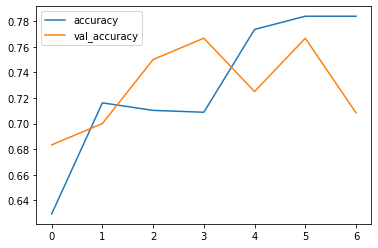

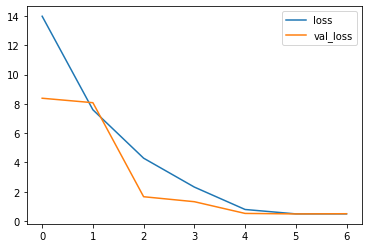

In [ ]:
history_cov2d = pd.DataFrame(model.history.history)
history_cov2d[['accuracy', 'val_accuracy']].plot()
history_cov2d[['loss', 'val_loss']].plot()

the above figures shows that our model has performed well, we will use it to make predictions on any of the images gotten from the dataset that was used to train our model.
Below will be an implementation of predicting an image that belongs to a child

1/1 [==============================] - 10s 10s/step
this image likely belongs to children


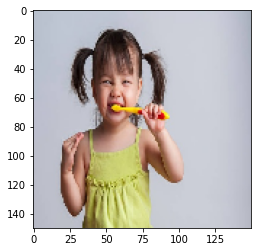

In [ ]:
import tensorflow as tf
from  tensorflow.keras.preprocessing import image
def make_your_prediction(YOUR_IMAGE_PATH=None):
    if YOUR_IMAGE_PATH == None:
        YOUR_IMAGE_PATH = r'../tochora/65.jpg'
    img = image.load_img(YOUR_IMAGE_PATH, target_size=(150, 150))
    plt.imshow(img)
    x = image.img_to_array(img)
    x /= 255
    x = np.expand_dims(x, axis=0)
    images = np.vstack([x])
    classes = model.predict(images, batch_size=10)
    score = tf.nn.sigmoid(classes[0])
    class_name = train_generator.class_indices
    class_name_inverted = {y:x for x, y in class_name.items()}
    if classes[0] > 0.5:
        print(f'this image likely belongs to {class_name_inverted[1]}')
    else:
        print(f'This image likely belongs to {class_name_inverted[0]}')
make_your_prediction(YOUR_IMAGE_PATH=None)


cool! it seem our model has performed well